Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    ! pip install systole

In [2]:
import pandas as pd
from systole.detection import ecg_peaks
from systole import import_dataset1

from bokeh.io import output_notebook
from bokeh.plotting import show
from bokeh.layouts import row, column
output_notebook()

Loading BokehJS ...

# Heart rate variability

After having preprocessed the ECG or PPG signal, performed peaks detection and artefacts correction, we discuss here the extraction of heart rate variability (**HRV**) indices.

A healthy heart, and a healthy brain-heart connection, does not result in a stable and never-changing cardiac activity. On the contrary, the heart rate variability (the amount of change from one RR interval to the next) can be largely different across individuals and across time for the same individual. A considerable literature has documented the robust relations between various HRV indices and both physical and mental health (see **[1]**). Extracting these indices can therefore be one of the first steps in the process of analysing and quantifying the cardiac signal. 

The heart rate variability indices are often split into three different sub-domain: *1.* the time domain, *2.* the frequency domain and *3.* the nonlinear domain (see **[2]** for review). The rationale of this repartition consist mostly in the nature of the statistical and mathematical operations performed to compute the indices, and the interpretation you can make of it. While the time domain looks at the distribution of the RR intervals as a whole and will examine different aspects of its spread and variance, the frequency domain interpolate the RR time-series and will extract the power of different frequency bands of interest. The nonlinear approach capitalizes on the notion that the variations found in RR time series can often be nonlinear and uses mathematical derivation from probability and chaos theories to quantify its chaotic/flatness dimension.

[Systole](https://systole-docs.github.io/) only implement a small number of all the HRV indices that have been proposed in the literature. They are, however, the most widely used, the most often reported and, for the most part, the most interpretable ones. It is also worth noting that high colinearity exists among all the HRV variables, and they can often be reduced to a few significant dimensions **[3]**.

HRV analysis quantifies the cardiac variability for a given recording taken as a whole. The recommendation for this kind of analysis is that the signal should be at least 5 minutes long ideally, and not shorter than 2 minutes (even if recording as short as 10 seconds, aka ultra short term HRV, can give reliable results for some domains (e.g. **[4]**). On the other side, some indices from the frequency domain focusing on very slow fluctuation can require recording of 24 hours or more to be estimated reliably. 

In [3]:
# Import ECg recording
signal = import_dataset1(modalities=['ECG'], disable=True).ecg.to_numpy()

# R peaks detection
signal, peaks = ecg_peaks(signal, method='pan-tompkins', sfreq=1000)

In Systole, the HRV indices can be found in the `systole.hrv` submodule. For most of the indices, it can be imported individually, such as:

In [4]:
from systole.hrv import rmssd

This will import the RMSSD function that will compute the *Root Mean Square of the Successive Differences*, which is an often-used indice from the time domain dimension that is known to reflect the short-term heart rate variability, which evolves under the influence of the parasympathetic nervous system. Following [Systole](https://systole-docs.github.io/)'s API, all the HRV functions have an `input_type` parameter that will let you compute the indices using either boolean `peaks` vectors, integer `peaks_idx` vectors, or the float RR interval vectors itself in milliseconds (`rr_ms`) or seconds (`rr_s`).

In [5]:
rmssd(peaks, input_type="peaks")

27.020577860345192

This approach will be more computationally efficient when working on a small number of indices as it allows to only retrieve some of them from the RR intervals. Other uses more focused on feature extraction can require to access all the possible indices or all of them in a specific domain. The `time_domain()`, `frequency_domain()` and `nonlinear_domain()` functions will return a data frame containing indices from the time, frequency or nonlinear domain respectively. The `all_domain()` function can be used to wrap all of this method in a single call and compute all the HRV metrics currently implemented in Systole.

## Time domain

In [6]:
from systole.hrv import time_domain

# Extract time domain heart rate variability
hrv_df = time_domain(peaks, input_type='peaks')

The data frame output is in the long format as it is more convenient to append it in a larger summary variable for a large number of groups/session/participants. Here we simply pivot it so it renders more nicely in the notebook:

In [7]:
pd.pivot_table(hrv_df, values='Values', columns='Metric')

Metric,MaxBPM,MaxRR,MeanBPM,MeanRR,MedianBPM,MedianRR,MinBPM,MinRR,RMSSD,SDNN,SDSD,nn50,pnn50
Values,126.05042,1041.0,75.97172,793.352789,75.093867,799.0,57.636888,476.0,27.020578,52.099676,27.027069,85.0,4.392765


## Frequency domain

Using a similar approach, indices from the frequency domains can be extracted from RR intervals time-series. Here, we demonstrate how to plot and render an output table for frequency domain indices. Systole includes tables functions that can print the table of results using either [tabulate](https://github.com/astanin/python-tabulate) or [Bokeh](https://docs.bokeh.org/en/latest/index.html) for better rendering in the notebook. Those are located in the `systole.plots` submodule. Here we use [tabulate](https://github.com/astanin/python-tabulate) (note that it is called inside a print function).

=================  ============  =============  ===========  ==============
Frequency Band       Peaks (Hz)    Power (ms²)    Power (%)    Power (n.u.)
=================  ============  =============  ===========  ==============
VLF (0-0.04 Hz)          0.0078      1439.9078      66.5951
LF (0.04-0.15 Hz)        0.0938       472.3333      21.8452         65.3953
HF (0.15-0.4 Hz)         0.3555       249.9409      11.5597         34.6047
Total                                2162.1820
LF/HF                                   1.8898
=================  ============  =============  ===========  ==============


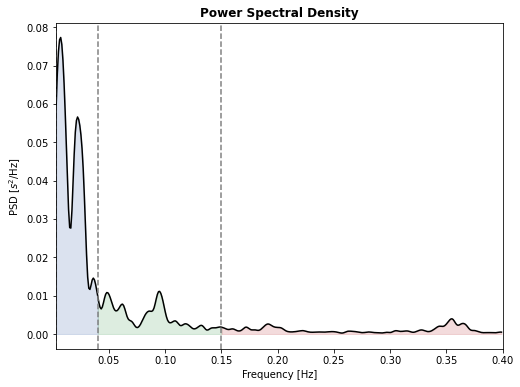

In [8]:
from systole.plots import plot_frequency
from systole.plots.utils import frequency_table

# Print frequency table
print(
    frequency_table(peaks, input_type='peaks', backend="tabulate")
)

# Plot PDS using Matplotlib
plot_frequency(peaks, input_type='peaks');

## Nonlinear domain
The nonlinear domain indices are accesible using the same API. Here, we demonstrate how to report it using [Bokeh](https://docs.bokeh.org/en/latest/index.html) only.

In [9]:
from systole.plots import plot_poincare
from systole.plots.utils import nonlinear_table

In [10]:
show(
    row(
        plot_poincare(peaks, input_type='peaks', backend='bokeh'),
        nonlinear_table(peaks, input_type='peaks', backend='bokeh')
    )
)

## Creating HRV summary

These function can be modularily concatenated to render HRV dashboard. Here is an exampe for an HTML report using [Bokeh](https://docs.bokeh.org/en/latest/index.html) functions.

In [11]:
from systole.plots import plot_poincare, plot_frequency, plot_rr
from systole.plots.utils import nonlinear_table, frequency_table

show(
    column(
        plot_rr(peaks, input_type="peaks", backend="bokeh"),
        row(
            plot_frequency(peaks, input_type="peaks", backend="bokeh", figsize=(400, 400)),
            frequency_table(peaks, input_type="peaks", backend="bokeh"),
        ),
        row(
            plot_poincare(peaks, input_type="peaks", backend="bokeh", figsize=(400, 400)),
            nonlinear_table(peaks, input_type="peaks", backend="bokeh"),
        )
    )
)

# References

**[1]** Thayer, J. F., & Lane, R. D. (2009). Claude Bernard and the heart–brain connection: Further elaboration of a model of neurovisceral integration. In Neuroscience & Biobehavioral Reviews (Vol. 33, Issue 2, pp. 81–88). Elsevier BV. https://doi.org/10.1016/j.neubiorev.2008.08.004 

**[2]** Pham T, Lau ZJ, Chen SHA, Makowski D. Heart Rate Variability in Psychology: A Review of HRV Indices and an Analysis Tutorial. Sensors. 2021; 21(12):3998. https://doi.org/10.3390/s21123998

**[3]** Pham, T., Lau, Z., Chen, S. A., & Makowski, D. (2021, October 26). Unveiling the Structure of Heart Rate Variability (HRV) Indices: A Data-driven Meta-clustering Approach. https://doi.org/10.31234/osf.io/mwa6x

**[4]** Munoz, M. L., van Roon, A., Riese, H., Thio, C., Oostenbroek, E., Westrik, I., de Geus, E. J. C., Gansevoort, R., Lefrandt, J., Nolte, I. M., & Snieder, H. (2015). Validity of (Ultra-)Short Recordings for Heart Rate Variability Measurements. In X. Chen (Ed.), PLOS ONE (Vol. 10, Issue 9, p. e0138921). Public Library of Science (PLoS). https://doi.org/10.1371/journal.pone.0138921 